## Source https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


### First read the data and take an overview

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Dataset contains 866 NaN values which is significant number. It is better idea to fill NaN values with unique value than to drop these rows. For numeric column it is -1, for object columns 'Unknown'

In [6]:
values = {"Age":-1,"Cabin":"Unknown","Embarked":"Unknown"}
df = df.fillna(value=values)

### Model construction

Let's define function to assign target variable and features, then run cross validation model

In [7]:
def model_func(features, model, scor, cv_num):
    X = df[features]
    y = df['Survived']
    return cross_val_score(model,X,y,scoring=scor, cv=cv_num).mean()


And test this function on an early stage

In [8]:
features = (["Pclass","Age","Parch","Fare","SibSp"])
model_func(features,RandomForestClassifier(),"accuracy",4)

c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6846208846979587

### Feature Engineering

First most obvious thought is to switch Sex column into 0, 1 values. Take a look whether it contains only two categories

In [9]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
df['Sex_cat'] = df["Sex"].map(lambda x: int(x=='male'))

Cabin column

In [11]:
df['Cabin'].value_counts()

Unknown        687
G6               4
C23 C25 C27      4
B96 B98          4
C22 C26          3
D                3
E101             3
F2               3
F33              3
B35              2
B51 B53 B55      2
E44              2
B18              2
B28              2
C126             2
C92              2
C52              2
B58 B60          2
B77              2
E67              2
D36              2
C65              2
C123             2
E25              2
E33              2
C93              2
D26              2
E8               2
D17              2
B5               2
              ... 
F E69            1
A20              1
C46              1
B82 B84          1
A6               1
B4               1
E63              1
B42              1
D10 D12          1
C99              1
E50              1
D15              1
D7               1
C106             1
D48              1
D28              1
B80              1
C110             1
B86              1
E49              1
D50              1
E58         

That doesn't tell too much. Let's extract first letter; Unknown is U. 

In [12]:
def first_letter(string):
    if not string[0].isdigit():
        return string[0]
    

In [13]:
df['Cabin_letter'] = df['Cabin'].apply(first_letter)

In [14]:
df['Cabin_letter'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_letter, dtype: int64

Make two columns based on previous. U and the rest of values. Also factorize all values.

In [15]:
df["Cabin_letter_U"] = df["Cabin_letter"].map(lambda x: int(x=="U"))
df["Cabin_letter_factorize"] = df["Cabin_letter"].factorize()[0]

Name column. Notice that every title is after comma ends with period. It allows to easily extract this title from the Name

In [16]:
df["Title"] = df["Name"].map(lambda x: x.split(",")[1].split('.')[0].strip())

In [17]:
df.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Jonkheer          1
the Countess      1
Mme               1
Capt              1
Sir               1
Don               1
Lady              1
Ms                1
Name: Title, dtype: int64

To simpify make a column with only four first titles and the others

In [18]:
top_titles = list(df['Title'].value_counts().head(4).keys())
top_titles

['Mr', 'Miss', 'Mrs', 'Master']

In [19]:
def title_top(title):
    if title in top_titles:
        return title
    else:
        return "other"

In [20]:
df['Title_top'] = df['Title'].apply(title_top)

In [21]:
df["Title_top_fact"] = df["Title_top"].factorize()[0]

In [22]:
df["Title_top"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
other      27
Name: Title_top, dtype: int64

Embarked column (Port of embarkation)

In [23]:
df["Embarked"].value_counts()

S          644
C          168
Q           77
Unknown      2
Name: Embarked, dtype: int64

Simply factorize

In [24]:
df["Embarked_cat"] = df["Embarked"].factorize()[0]

Number of siblings/spouse and parents/children aboard

In [25]:
df["Family_size"] = df['SibSp'] + df['Parch']
df["Family_size"].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family_size, dtype: int64

If Family size is 0 then there is a loner

In [26]:
df["Loner"] = df["Family_size"].map(lambda x: x==0)

Fare column

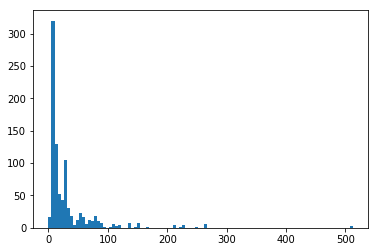

In [27]:
plt.hist(df["Fare"], bins=100)
plt.show()

Consider splitting fare into four categories: 0-50, 50-100, 100-200, 200-300 more than 300

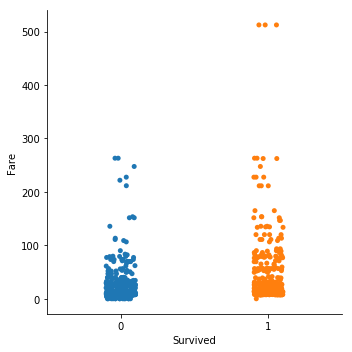

In [28]:
sns.catplot(x ='Survived', y = 'Fare', data = df)

In [29]:
def fare_cats(fare):
    if 0 <= fare < 50:
        return 0
    elif 50 <= fare < 100:
        return 1
    elif 100 <= fare < 200:
        return 2
    elif 200 <= fare < 300:
        return 3
    elif fare >= 300:
        return 4

In [30]:
df["Fare_cats"] = df["Fare"].apply(fare_cats)
df["Fare_cats"].value_counts()

0    730
1    108
2     33
3     17
4      3
Name: Fare_cats, dtype: int64

Age column - Combine data with Sex column and divide into three categories: child (less than 16 yo), female adult and male adult

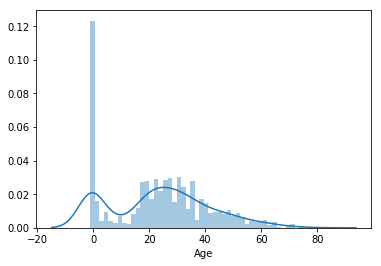

In [31]:
sns.distplot(df['Age'], bins=50)

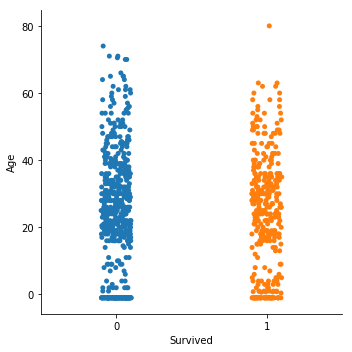

In [32]:
sns.catplot(x = 'Survived', y = 'Age', data = df)

No explicit pattern. Make a column indicating previous NaN (-1) value.

In [33]:
df['Age_NaN'] = df['Age'].map(lambda x: x==-1)

Combine data with Sex column and divide into three categories: child (less than 16 yo), female adult and male adult

In [34]:
def child_adult_sex(age, sex):
    if age <= 16: return 'child'
    elif sex == 'male': return 'male_adult'
    elif sex == 'female':return 'female_adult'

In [35]:
df['child_adult_sex'] = df.apply(lambda x: child_adult_sex(x.Age, x.Sex), axis=1)

In [36]:
df['child_adult_sex_fact'] = df['child_adult_sex'].factorize()[0]

### Pivot tables

It may be inventive to use pivot to see what percentage of survivors is while we combine two features together

In [37]:
df.pivot_table(values=['Survived'], index = ["Sex","Pclass"], aggfunc=np.mean)

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

In [38]:
df.pivot_table(values=['Survived'], index = ["Title_top","Pclass"], aggfunc=np.mean)

Survived
Title_top Pclass          
Master    1       1.000000
          2       1.000000
          3       0.392857
Miss      1       0.956522
          2       0.941176
          3       0.500000
Mr        1       0.345794
          2       0.087912
          3       0.112853
Mrs       1       0.976190
          2       0.902439
          3       0.500000
other     1       0.611111
          2       0.111111

In [39]:
df.pivot_table(values=['Survived'], index = ["Embarked","Pclass"], aggfunc=np.mean)

Survived
Embarked Pclass          
C        1       0.694118
         2       0.529412
         3       0.378788
Q        1       0.500000
         2       0.666667
         3       0.375000
S        1       0.582677
         2       0.463415
         3       0.189802
Unknown  1       1.000000

Masters, misses and Mrs from class 1 and 2 had great chance to survive. Create a column which points them with 1

In [40]:
def title_pclass(title, pclass):
    if pclass in [1,2]:
        if title in ['Master','Miss','Mrs']:
            return 1
        else:
            return 0
    else:
        return 0

In [41]:
df['title_pclass'] = df.apply(lambda x: title_pclass(x.Title_top,x.Pclass), axis=1)

### Correlation

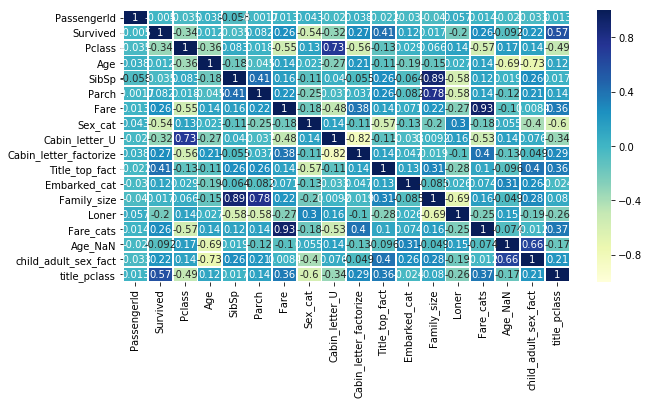

In [42]:
plt.rcParams['figure.figsize']=(10,5)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

Heatmap above shows how particula features correlate with each other. This may be helpful while determinig which feature improves model, which not and which is redundand (has strong correlation with column other than Target and can be omitted).

## Model adjusting

First select features with most correlation and run for a few models

In [43]:
models = [RandomForestClassifier(),DecisionTreeClassifier(),xgb.XGBClassifier()]

features = (["title_pclass","Fare_cats","Cabin_letter_factorize","Sex_cat","Age","Family_size","child_adult_sex_fact",
             "Title_top_fact","Age_NaN","Parch","Loner"])
for model in models:
    
    print("Model {0} reached accuracy {1}".format(model, model_func(features,model,"accuracy",4)))


c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\python 3.7\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) reached accuracy 0.8125963988492015
Model DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') reached accuracy 0.794664003569553
Model XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta

Approximately XGBClassifier is doing best job.

Now, try to choose randomly features and find what combination has the greatest potential.

In [44]:
best_score = 0
best_feats = []

X = np.array(['Pclass','Age','SibSp','Parch','Fare','Sex_cat','Cabin_letter_U','Cabin_letter_factorize','Title_top_fact',
              'Embarked_cat','Family_size','Loner','Fare_cats','Age_NaN','child_adult_sex_fact','title_pclass'])

for i in range(1,17): # there are 16 numeric or bool features
    for a in range(35): # 30 times loop
        features = np.random.choice(X,i,replace = False).tolist()
        score = model_func(features,xgb.XGBClassifier(),"accuracy",4)
        
        if score > best_score:
            best_score = score
            best_feats = features


print('Best score is {0} with features: {1}'.format(best_score,best_feats))
        


Best score is 0.8417749057112845 with features: ['Sex_cat', 'child_adult_sex_fact', 'Family_size', 'Embarked_cat', 'Title_top_fact', 'title_pclass', 'Fare_cats', 'Pclass', 'SibSp', 'Cabin_letter_factorize', 'Age_NaN', 'Age', 'Parch', 'Loner']


To be continued...